# Required libraries

In [32]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from derivative import dxdt
import pandas as pd

import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


# Frailty Index Model

# $\frac{df}{dt} = a \cdot (1-f)   \cdot (1+bt) - fr(1-st)$


# Mortality Model

# $\mu = \mu_0 f(t)^c$


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


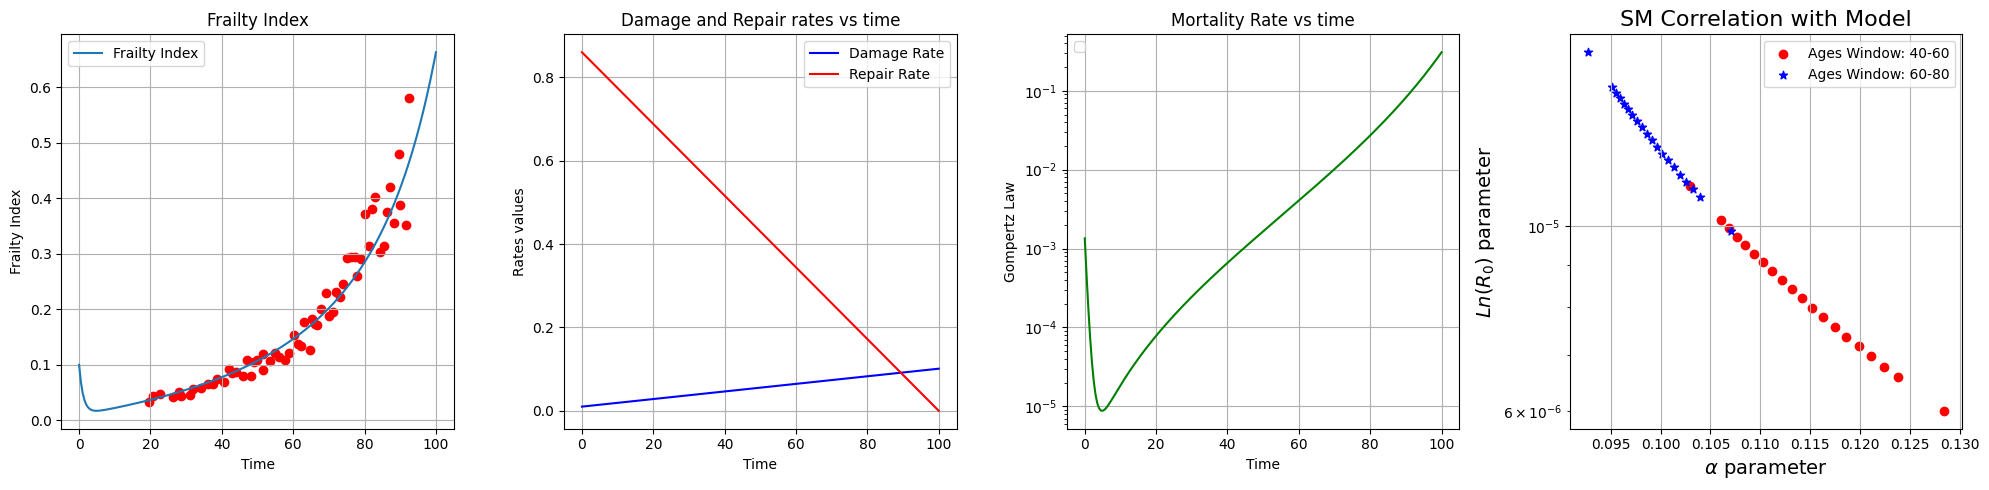

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


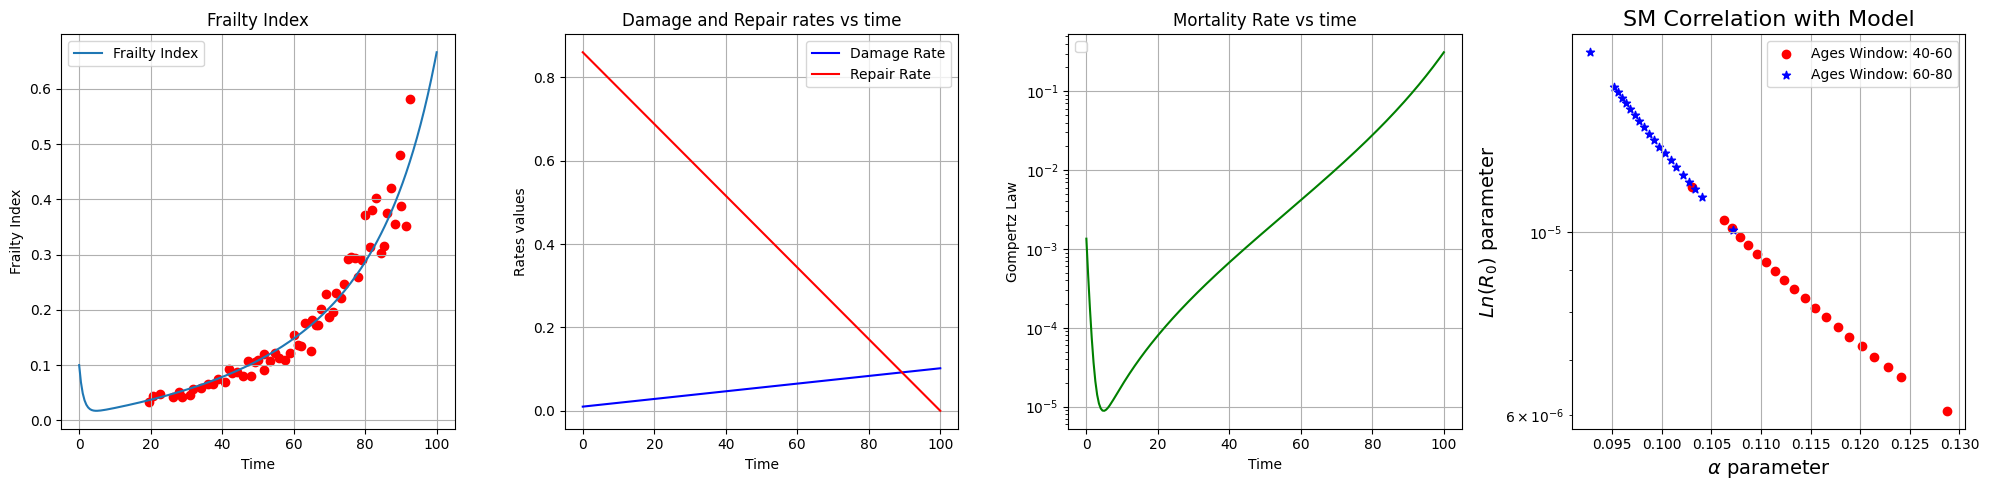

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


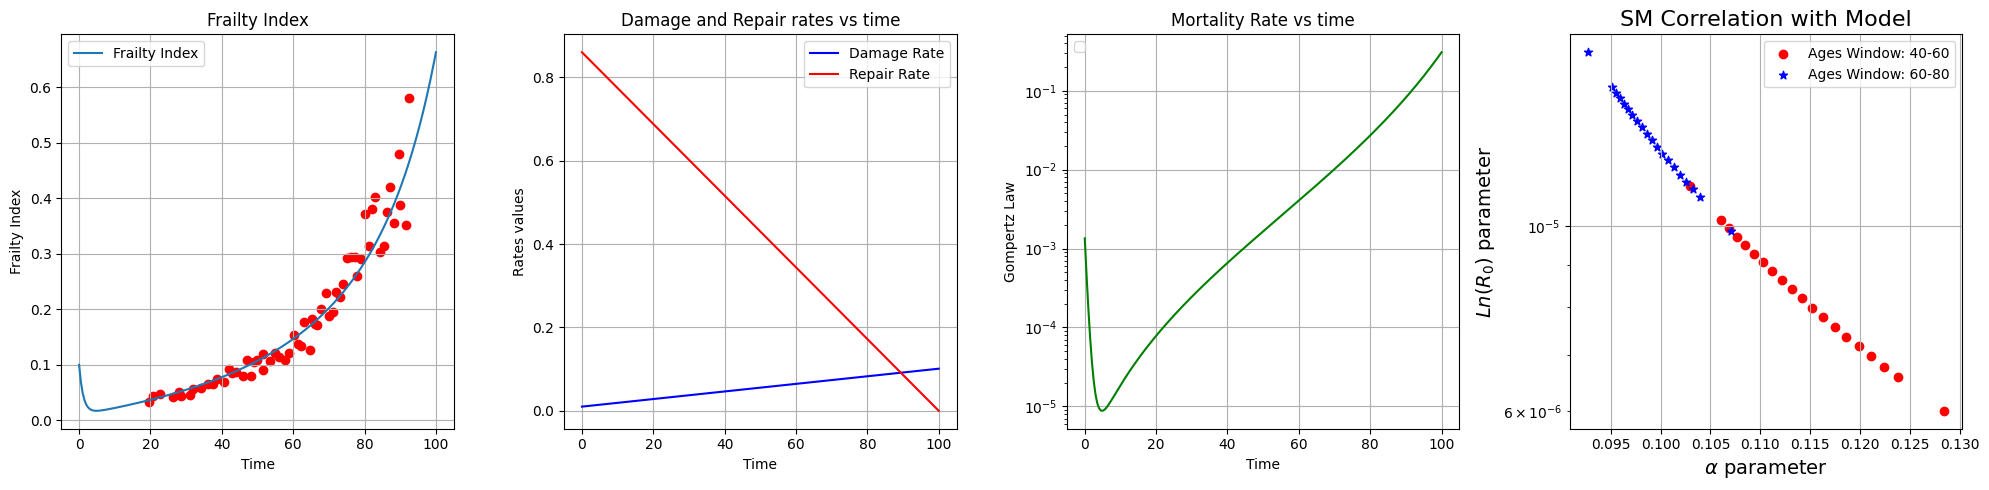

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


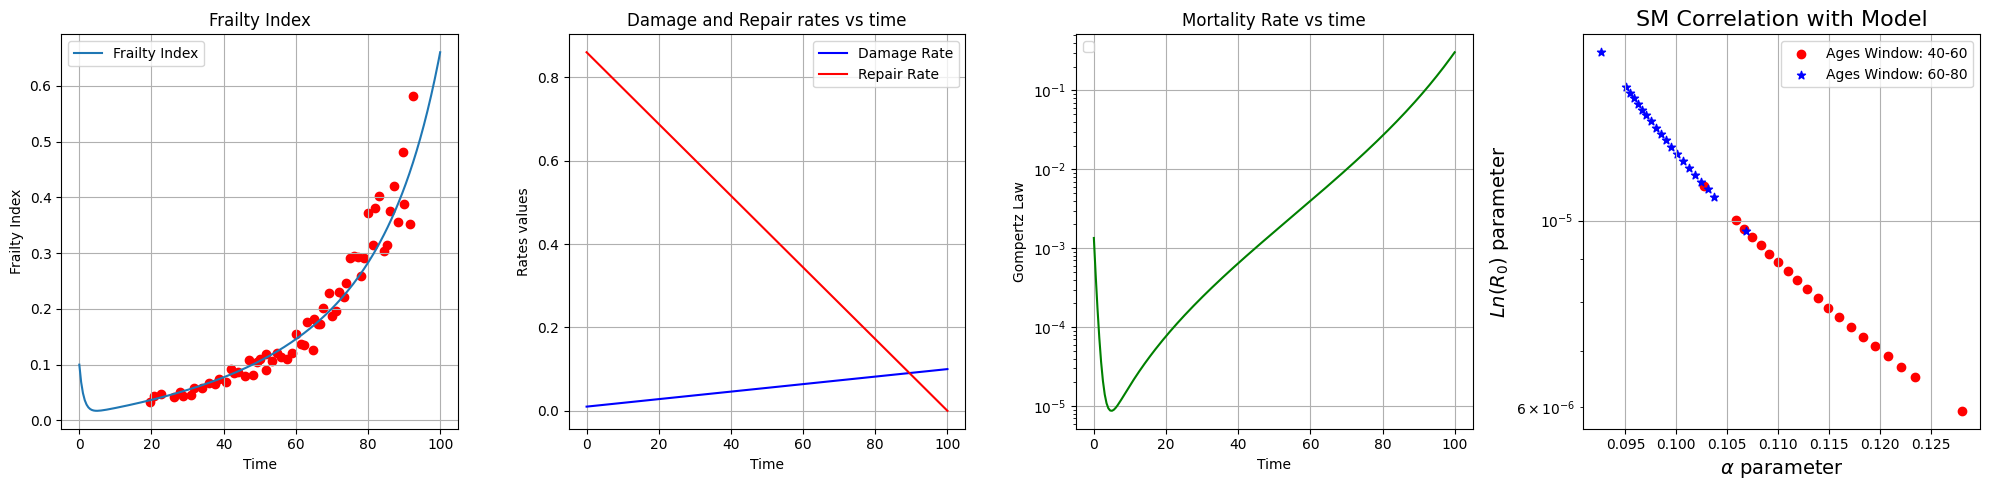

In [37]:
# Differential equation of the frailty index
def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    return dfdt

# Time points
t = np.linspace(0, 100, 200)  # 100 time steps from 0 to 10

# Default initial conditions and parameters
f0 = 0.1
a = 0.01
b = 0.09
r = 0.86
s = 0.01

# Function for the plots with new parameters values
def update_plot(a, b, r, s, initial_condition):
    f_solution = odeint(frailty_index_differential_equation, initial_condition, t, args=(a, b, r, s)) #Solution of the differential equation using Odeint

    valor_damage_rate = a*(1+b*t) #Damage rate function
    valor_repair_rate = r*(1-s*t) #Repair rate function

    c = 2.87 #Parameter value of the exponent in the power law mortality model
    frailty_index = []
    for i in f_solution:
        frailty_index.append(i[0])
    frailty_index = np.array(frailty_index)
    gompertz_law_differential_equation = frailty_index**c #Gompertz law data using power law mortality model

    file_path = 'Frailty_Phen.csv' #Observational data for the Frailty Index in the paper: DOI 10.1007/s10522-017-9684-x
    data = pd.read_csv(file_path)

    x_values = data['X'] #Age of the observational data
    y_values = data['Y'] #Frailty index of the observational data

    #_________________________________________________________________________________
    #Calculation for instantaneous values of alpha and Ro with the Gompertz law

    edad_40_60 = t[40:60]
    data_40_60 = gompertz_law_differential_equation[40:60]
    derivative_process = dxdt(data_40_60, edad_40_60, kind="finite_difference", k=1)
    beta_values_40_60 = derivative_process/data_40_60
    R_values_40_60 = data_40_60/np.e**(beta_values_40_60*edad_40_60)

    edad_60_80 = t[60:80]
    data_60_80 = gompertz_law_differential_equation[60:80]
    derivative_process = dxdt(data_60_80, edad_60_80, kind="finite_difference", k=1)
    beta_values_60_80 = derivative_process/data_60_80
    R_values_60_80 = data_60_80/np.e**(beta_values_60_80*edad_60_80)

    #_________________________________________________________________________________

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    
    ax1.plot(t, f_solution, label='Frailty Index')
    ax1.scatter(x_values, y_values, color = "red")
    ax1.set_xlabel(r'Time')
    ax1.set_ylabel(r'Frailty Index')
    ax1.set_title(r'Frailty Index')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(t, valor_damage_rate, color = "blue", label = "Damage Rate")
    ax2.plot(t, valor_repair_rate, color = "red", label = "Repair Rate")
    ax2.set_xlabel(r'Time')
    ax2.set_ylabel(r'Rates values')
    ax2.set_title(r'Damage and Repair rates vs time')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(t, gompertz_law_differential_equation, color = "green")
    ax3.set_xlabel(r'Time')
    ax3.set_ylabel(r'Gompertz Law')
    ax3.set_title(r'Mortality Rate vs time')
    ax3.legend()
    ax3.set_yscale("log")
    ax3.grid(True)

    ax4.scatter(beta_values_40_60, R_values_40_60, color = "red" ,label = "Ages Window: 40-60")
    ax4.scatter(beta_values_60_80, R_values_60_80, color= "blue", marker='*' ,label = "Ages Window: 60-80")
    ax4.set_title("SM Correlation with Model", fontsize = 16)
    ax4.set_xlabel(r"$\alpha$ parameter", fontsize = 14)
    ax4.set_ylabel(r"$Ln(R_0)$ parameter", fontsize = 14)
    ax4.set_yscale("log")
    ax4.legend()
    ax4.grid(True)

    #plt.savefig("Frailty_Rates_Mortality.jpg", dpi = 1000)

    fig.tight_layout()

# Sliders for interactive parameter adjustment
slider_a = widgets.FloatSlider(value=a, min=0.0, max=1.0, step=0.001, description='a:')
slider_b = widgets.FloatSlider(value=b, min=0, max=2, step=0.001, description='b:')
slider_r = widgets.FloatSlider(value=r, min=0, max=1, step=0.001, description='r:')
slider_s = widgets.FloatSlider(value=s, min=0, max=0.01, step=0.001, description='s:')
slider_initial_condition = widgets.FloatSlider(value=f0, min=0, max=1, step=0.1, description='Initial Condition:')

# Function to be called when sliders are changed
def on_value_change(change):
    a = slider_a.value
    b = slider_b.value
    r = slider_r.value
    s = slider_s.value
    initial_condition = slider_initial_condition.value
    update_plot(a, b, r, s, initial_condition)

# Function to the slider value change event
slider_a.observe(on_value_change, names='value')
slider_b.observe(on_value_change, names='value')
slider_r.observe(on_value_change, names='value')
slider_s.observe(on_value_change, names='value')
slider_initial_condition.observe(on_value_change, names='value')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


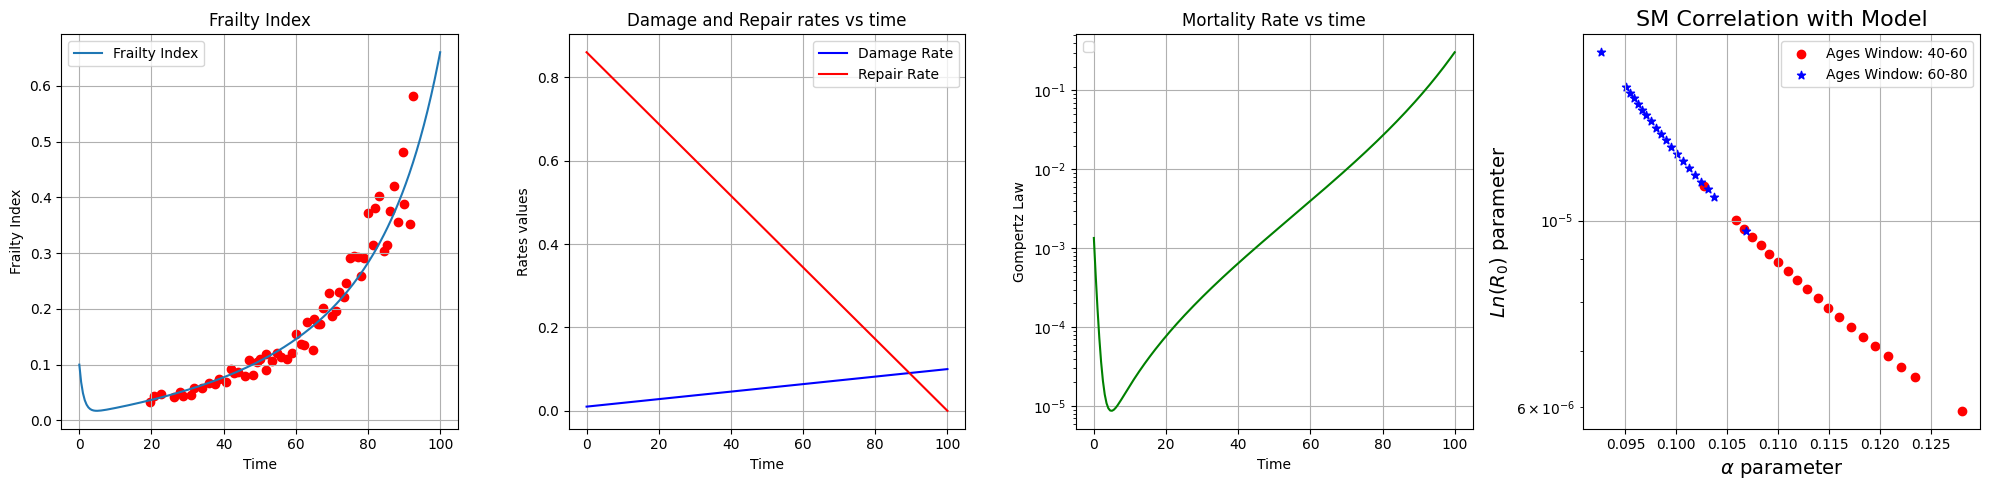

In [38]:
# Display the interactive plot and sliders
display(widgets.VBox([slider_a, slider_b, slider_r, slider_s, slider_initial_condition]))

update_plot(a, b, r, s, f0)  # Display the initial plot

# Parameters Optimization

In [60]:
# Differential equation of the frailty index
def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    return dfdt

# Time points


# Default initial conditions and parameters
f0 = 0.1
a = 0.01
b = 0.09
r = 0.86
s = 0.01

# Function for the plots with new parameters values

f_solution = odeint(frailty_index_differential_equation, f0, t, args=(a, b, r, s)) #Solution of the differential equation using Odeint

# Time points

file_path = 'Frailty_Phen.csv'
data = pd.read_csv(file_path)
x_values = data['X']  # Assuming 'X' is the header of the column for X coordinates
y_values = data['Y']  # Assuming 'Y' is the header of the column for Y coordinates

t_model =  np.linspace(20, 90, 200)  # 100 time steps from 0 to 10

# Function to calculate the objective (sum of squared differences)
def objective(params, t_model, data_time_points, data):

    d, alpha, r, s = params
    y0 = data[0]
    solution = odeint(frailty_index_differential_equation, 0.03702329, t_model, args=(d, alpha, r, s))
    
    # Interpolate X and Y data using cubic spline to match the model time points
    interp_Y = interp1d(x_values, y_values, kind='linear')(t_model)

    return np.sum((solution - interp_Y)**2)

# Initial guess for the parameters
initial_guess = [0.01, 0.09, 0.86, 0.01]



# Optimize parameters
bounds = [(0,1),(0,1),(0,1),(0,0.01)]
result = minimize(objective, initial_guess, args=(t_model, x_values, y_values), method='Powell', bounds=bounds)

# Extract optimized parameters
optimized_params = result.x
print("Optimized Parameters:", optimized_params)

solution = odeint(frailty_index_differential_equation, y_values[0], t_model, args=(optimized_params[0], optimized_params[1], optimized_params[2], optimized_params[3]))

/var/folders/9w/7pgd2w3n7j3fprw9mqstx8n80000gn/T/ipykernel_36316/447108475.py:3: RuntimeWarning: overflow encountered in multiply
  dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
/var/folders/9w/7pgd2w3n7j3fprw9mqstx8n80000gn/T/ipykernel_36316/447108475.py:3: RuntimeWarning: invalid value encountered in subtract
  dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
/var/folders/9w/7pgd2w3n7j3fprw9mqstx8n80000gn/T/ipykernel_36316/447108475.py:39: RuntimeWarning: overflow encountered in square
  return np.sum((solution - interp_Y)**2)
/Users/rafther0112/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/rafther0112/miniconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/rafther0112/miniconda3/lib/python3.11/site-packages/sci

Optimized Parameters: [3.07095445e-03 1.00000000e+00 9.89424927e-01 6.45639396e-05]


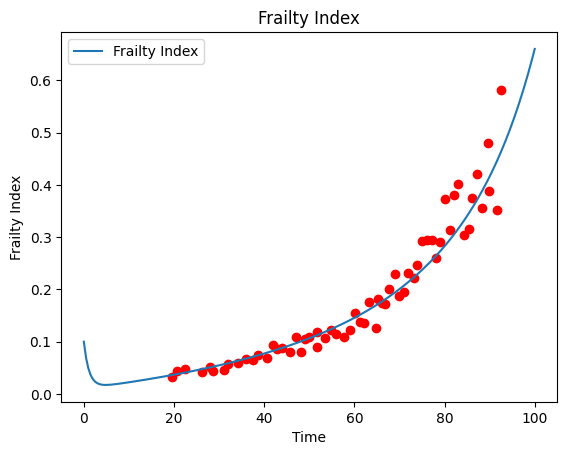

In [41]:
# Differential equation of the frailty index
def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    return dfdt

# Time points
t = np.linspace(0, 100, 200)  # 100 time steps from 0 to 10

# Default initial conditions and parameters
f0 = 0.1
a = 0.01
b = 0.09
r = 0.86
s = 0.01

# Function for the plots with new parameters values

f_solution = odeint(frailty_index_differential_equation, f0, t, args=(a, b, r, s)) #Solution of the differential equation using Odeint


plt.plot(t, f_solution, label='Frailty Index')
plt.scatter(x_values, y_values, color = "red")
plt.xlabel(r'Time')
plt.ylabel(r'Frailty Index')
plt.title(r'Frailty Index')
plt.legend()

    


In [56]:
f_solution[40]

array([0.03702329])